In [34]:
import sys, os, re
sys.path.append(os.path.abspath('../'))

from glob import glob
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from typing import List, Tuple

from tensorflow.python.keras.preprocessing.image_dataset import load_image
from tqdm import tqdm
import umap

from matplotlib import pyplot as plt
from IPython.display import display, HTML
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import utils

In [86]:
def get_feature_extractor(model_path: str):
    weights = "imagenet" if model_path is None else None
    print(f"Using weights: {weights}")
    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=weights,
    )
    base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs, x)
    if model_path is not None:
        print(f"Loading weights: {model_path}")
        model.load_weights(model_path)
    return model

def get_feature_map(model: tf.keras.Model, data_dir: str) -> Tuple[List[Path], np.ndarray]:
    image_paths = list(sorted(Path(data_dir).glob("**/*.png")))
    n_samples = len(image_paths)
    feature_map = np.zeros((n_samples, 256))
    with tqdm(total=n_samples) as pbar:
        for i, image_path in enumerate(image_paths):
            img = load_image(str(image_path), image_size=(32,32), num_channels=3, interpolation="bilinear")
            img = tf.expand_dims(img, axis=0) # TensorShape: [1, 32, 32, 3]
            img_features = model(img) # TensorShape: [1, 256]
            img_features = img_features.numpy().squeeze() # Shape: (256,)
            feature_map[i, :] = img_features
            pbar.update(1)
    return image_paths, feature_map

In [87]:
experiment_dir = "../experiments/original"

In [88]:
model_path = os.path.join(experiment_dir, "checkpoints", "best_model")
model_path = os.path.join(experiment_dir, "checkpoints", "imagenet-finetuned")
model_path = None

In [89]:
model = get_feature_extractor(model_path)

Using weights: imagenet


In [90]:
data_dir = os.path.join(experiment_dir, 'data', 'train', 'i')

In [91]:
image_paths, feature_map = get_feature_map(model, data_dir)

100%|██████████| 261/261 [00:03<00:00, 84.07it/s]


In [92]:
feature_map.shape

(261, 256)

In [93]:
features_2d = umap.UMAP().fit_transform(feature_map)

In [94]:
int(feature_map.shape[0] / 10)

26

In [95]:
outlier_detector = IsolationForest(n_estimators=1000)
if_labels = outlier_detector.fit_predict(feature_map)
if_labels

In [99]:
(if_labels == -1).sum()

11

In [96]:
outlier_svm = OneClassSVM()
outlier_svm_labels = outlier_svm.fit_predict(feature_map)
outlier_svm_labels

array([ 1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
        1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,
        1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
        1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1,
        1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,
        1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1,
       -1,  1,  1, -1,  1

In [97]:
(outlier_svm_labels == -1).sum()

130

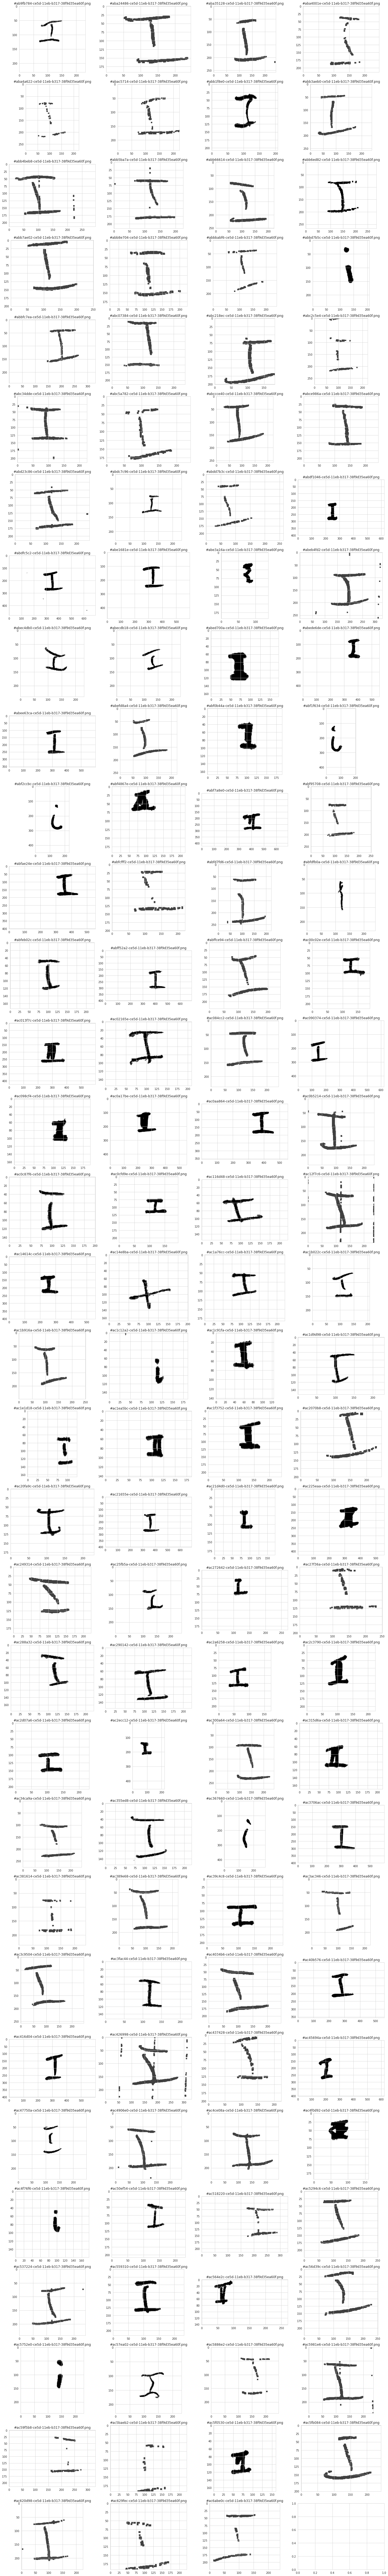

In [100]:
image_paths_in_cluster = np.array(image_paths)[(outlier_svm_labels == 1)]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [63]:
outlier_svm_labels.shape[0]

261

In [62]:
((if_labels== -1) | (outlier_svm_labels == -1)).sum()

131

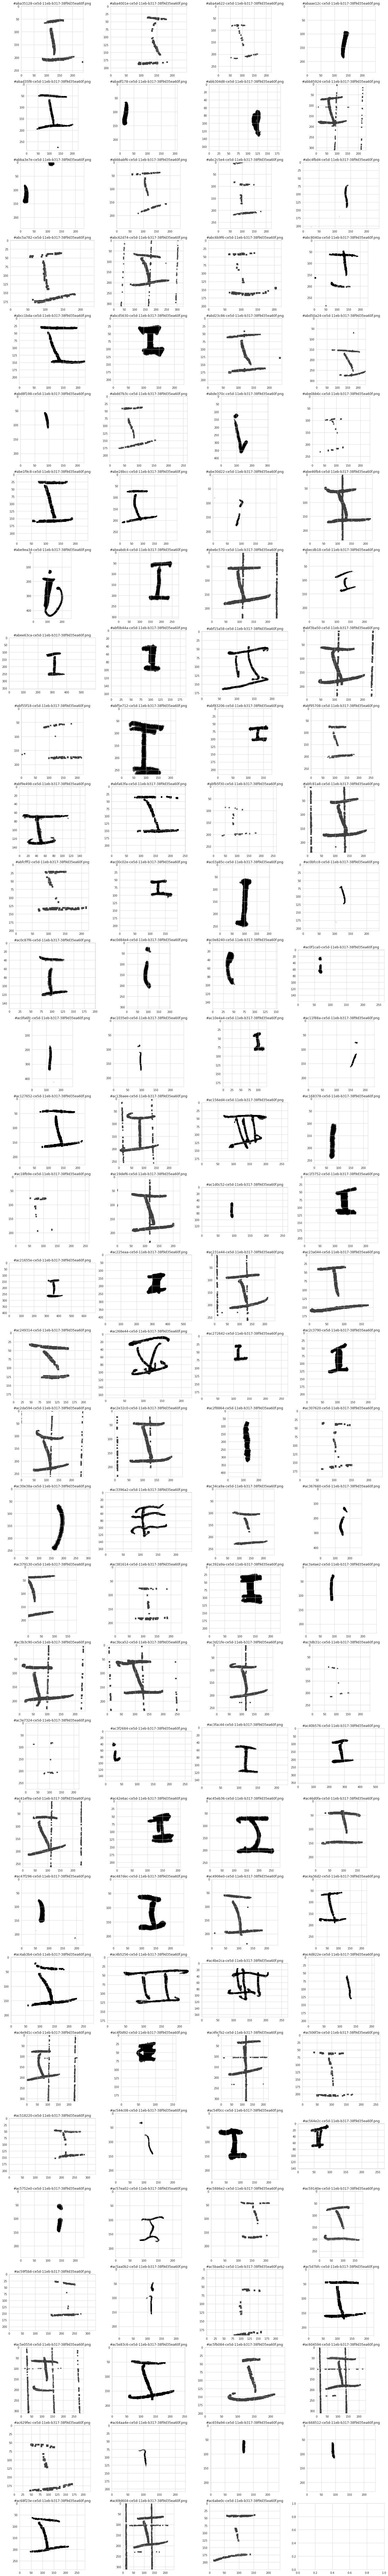

In [61]:
image_paths_in_cluster = np.array(image_paths)[(if_labels== -1) | (outlier_svm_labels == -1)]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

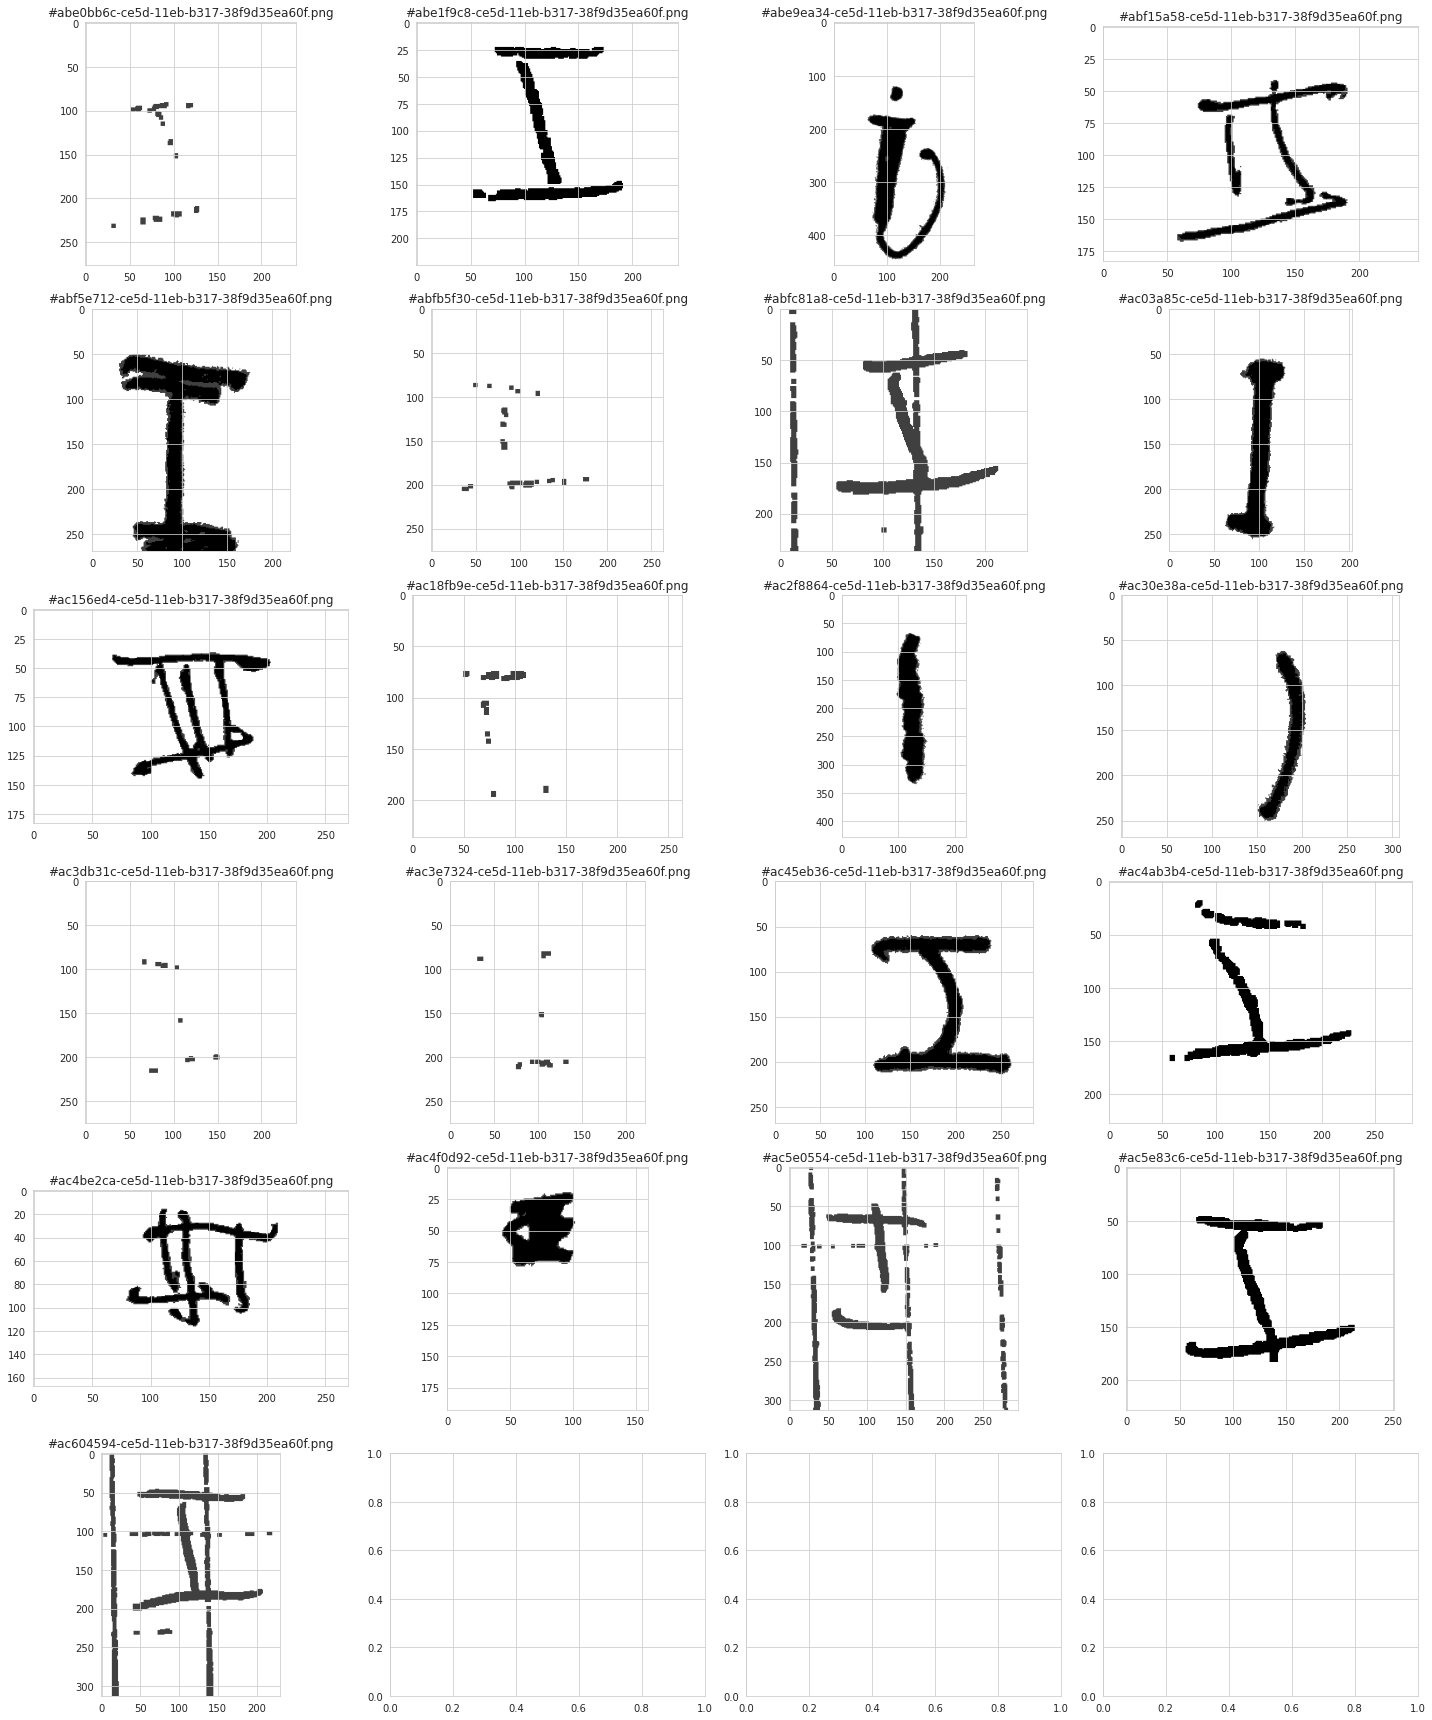

In [17]:


image_paths_in_cluster = np.array(image_paths)[if_labels == -1]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [38]:
km = KMeans(n_clusters=int(feature_map.shape[0] / 10), random_state=42, verbose=0, algorithm="full", n_init=20 )
kmeans_labels = km.fit_predict(feature_map)

In [58]:
b = Birch(n_clusters=3)
birch_labels = b.fit_predict(feature_map)

In [59]:
birch_labels

array([1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0,
       0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1,
       2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0,
       0, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 2, 1,
       1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1,
       1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2,
       0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1])

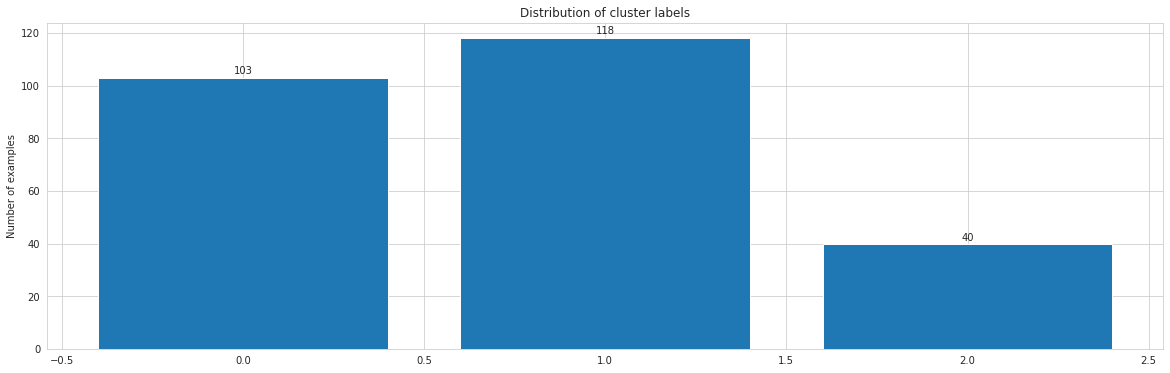

In [60]:
fig, ax = plt.subplots(figsize=(20, 6))
label_counts = np.bincount(birch_labels)
rects = ax.bar(range(len(label_counts)), label_counts)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % int(height), ha='center', va='bottom')
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of cluster labels");

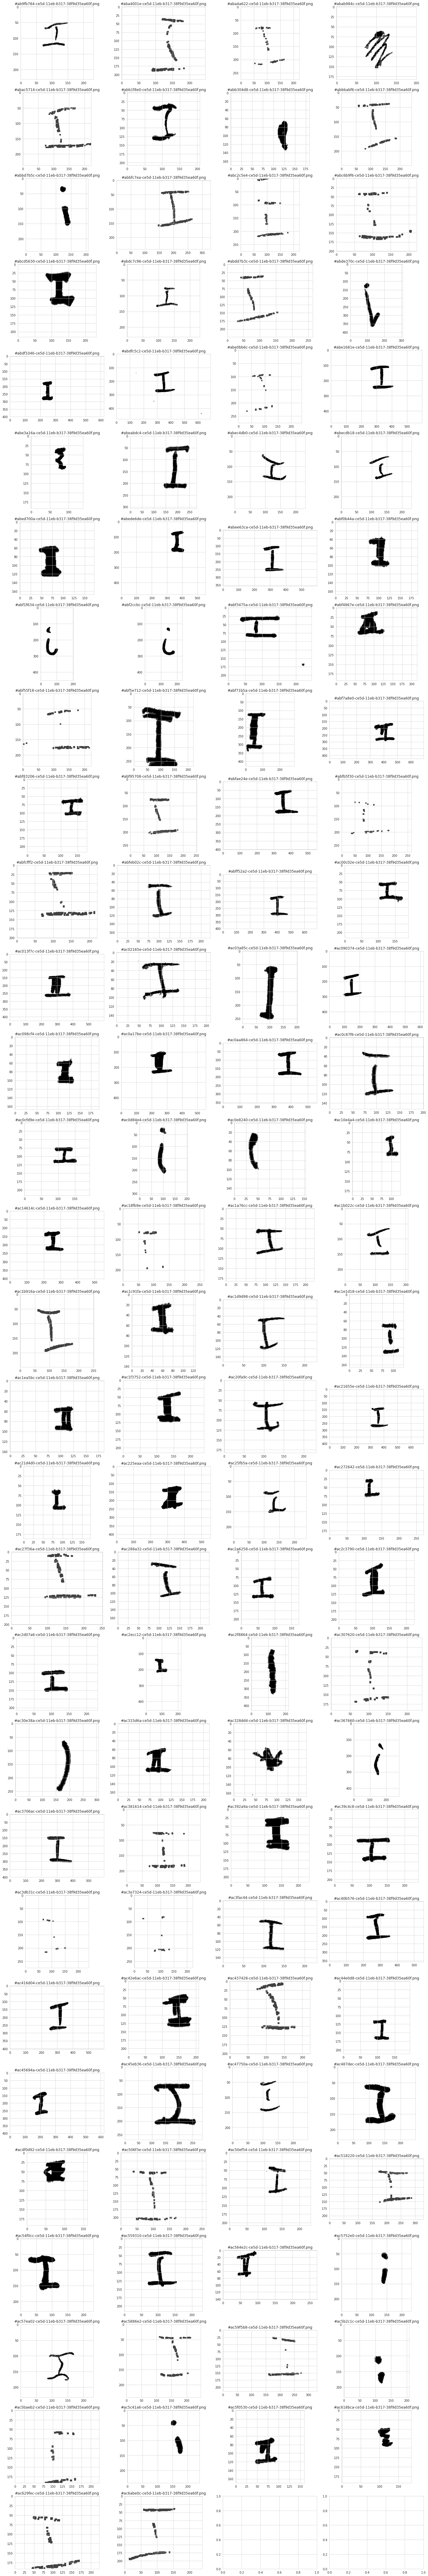

In [62]:
image_paths_in_cluster = np.array(image_paths)[birch_labels == 1]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [45]:
kmeans_labels.shape

(261,)

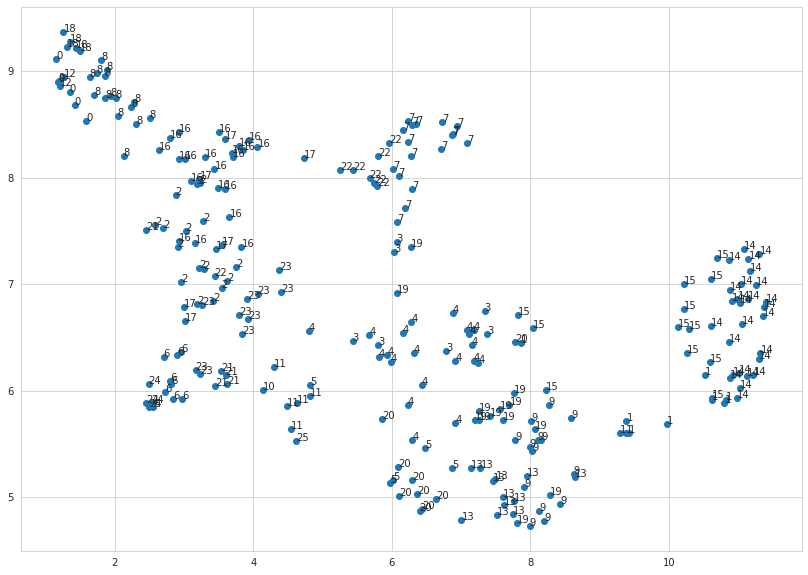

In [48]:
fig, ax = plt.subplots(figsize=(14, 10))
x_vals = features_2d[:,0]
y_vals = features_2d[:,1]
scatter = ax.scatter(x=x_vals, y=y_vals)
for i, txt in enumerate(range(kmeans_labels.shape[0])):
    ax.annotate(kmeans_labels[i], (x_vals[i], y_vals[i]))
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Cluster")

In [32]:
kmeans_labels

array([ 4, 17, 16,  3,  7,  2, 15,  3, 22, 24, 15, 11,  1,  2,  2, 16, 16,
       23, 16,  8, 16, 15, 22, 14,  1,  6, 19, 23,  2, 17,  7, 23,  2, 14,
       16,  8,  7, 23, 17,  2, 20,  1, 23, 16, 17, 14, 14,  9, 22,  3,  9,
        4,  7, 19,  6,  6, 15, 13, 18, 10, 11, 16, 18,  4,  4, 20,  9, 19,
        2, 20, 21,  4,  4,  5,  8, 13, 22, 25, 15,  5, 13,  9, 14, 22, 17,
        6, 19,  7, 14,  0, 22, 16, 14,  4, 19,  2, 15,  9, 13, 11, 20, 23,
        9, 13, 13, 19, 23, 14,  3,  9, 20, 15, 14, 15, 14,  9,  4, 14, 24,
        8,  0,  9, 16, 21, 14, 15,  7, 18,  4,  4,  4,  1,  5, 14,  3,  9,
       13, 20,  8, 16,  4, 19,  9, 13,  0, 17, 23, 14,  4, 21,  9,  7,  4,
       16,  6,  4, 14, 20,  4,  8,  0,  9, 20, 16,  7,  1, 13,  8,  3, 14,
       21,  2, 16, 16,  1,  1, 19, 22,  7,  2, 20,  4, 14, 23,  8,  8,  2,
       18,  7,  7, 14, 19, 16,  4, 19,  8,  8, 13,  3, 14,  9, 15, 11, 17,
        4, 15, 11, 16, 18,  6,  6, 24, 21,  8, 16, 14, 15,  8, 13, 14,  0,
        7, 19, 19,  8,  2

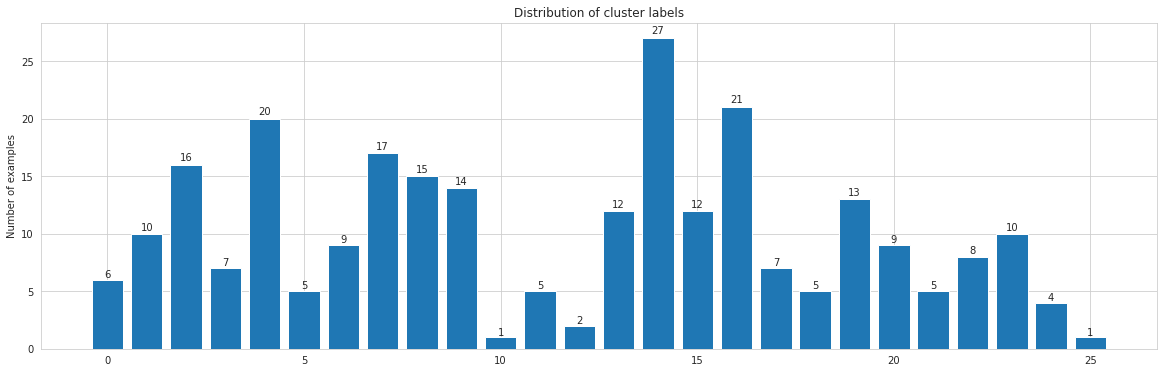

In [19]:
fig, ax = plt.subplots(figsize=(20, 6))
label_counts = np.bincount(kmeans_labels)
rects = ax.bar(range(len(label_counts)), label_counts)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % int(height), ha='center', va='bottom')
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of cluster labels");

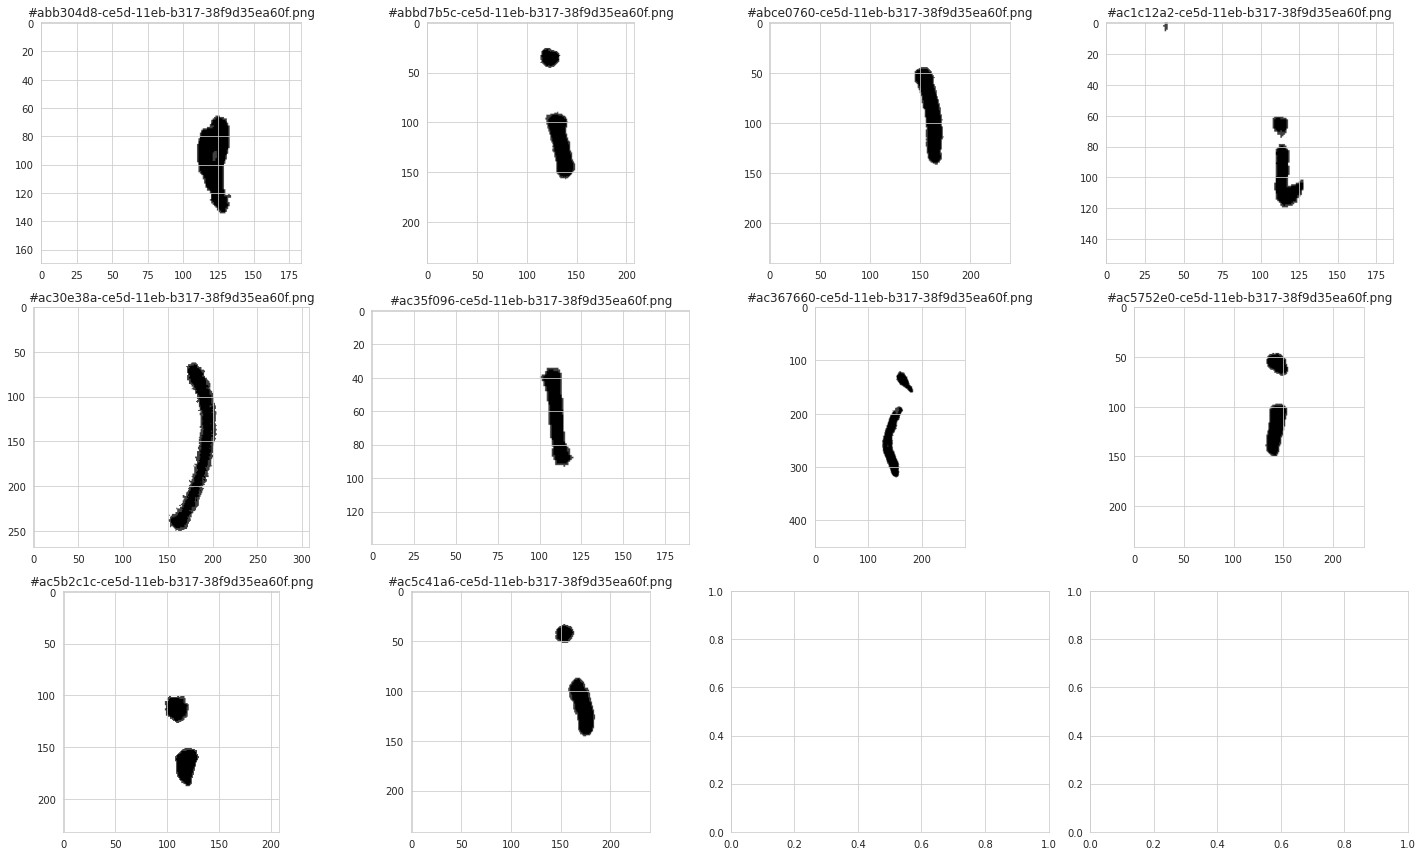

In [52]:
image_paths_in_cluster = np.array(image_paths)[kmeans_labels == 1]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

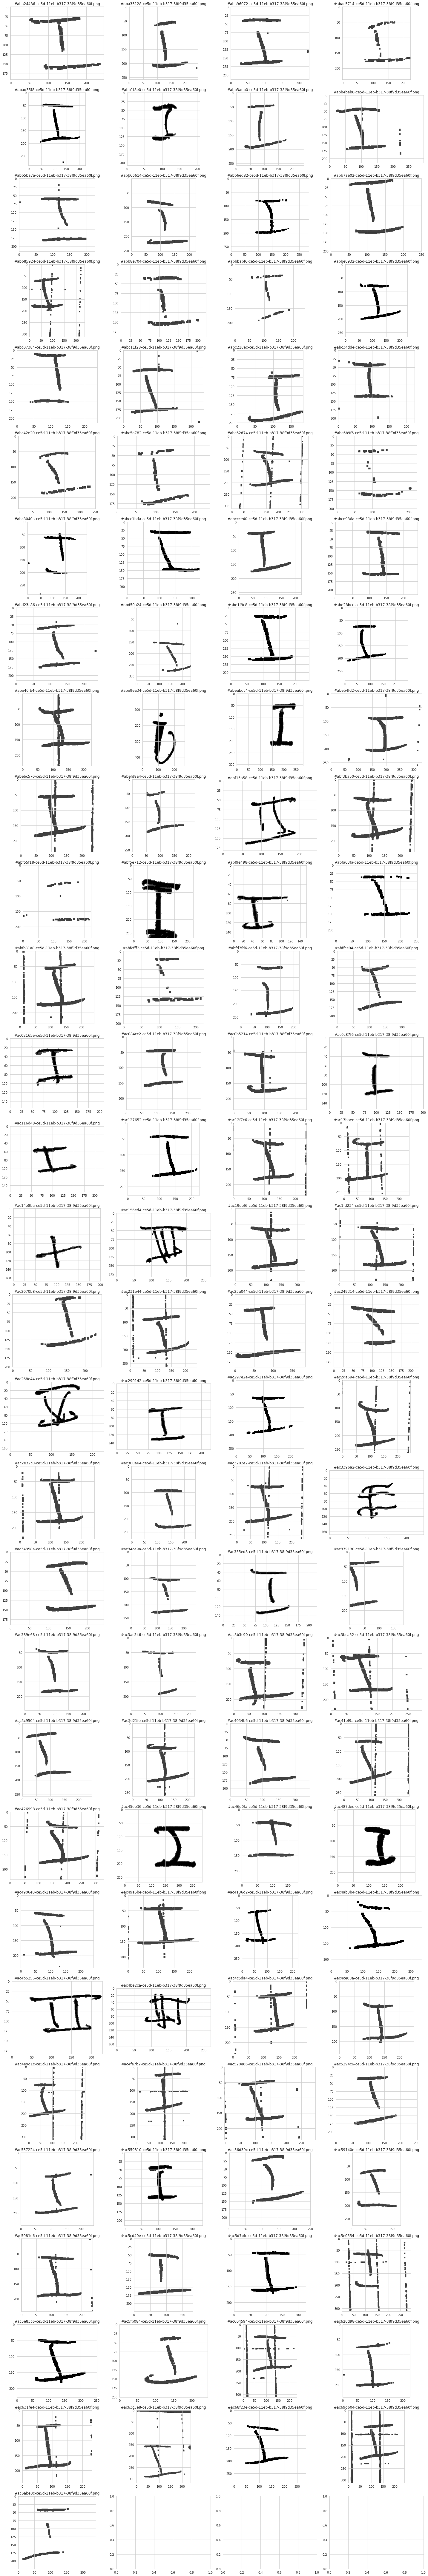

In [64]:
image_paths_in_cluster = np.array(image_paths)[kmeans_labels == 1]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

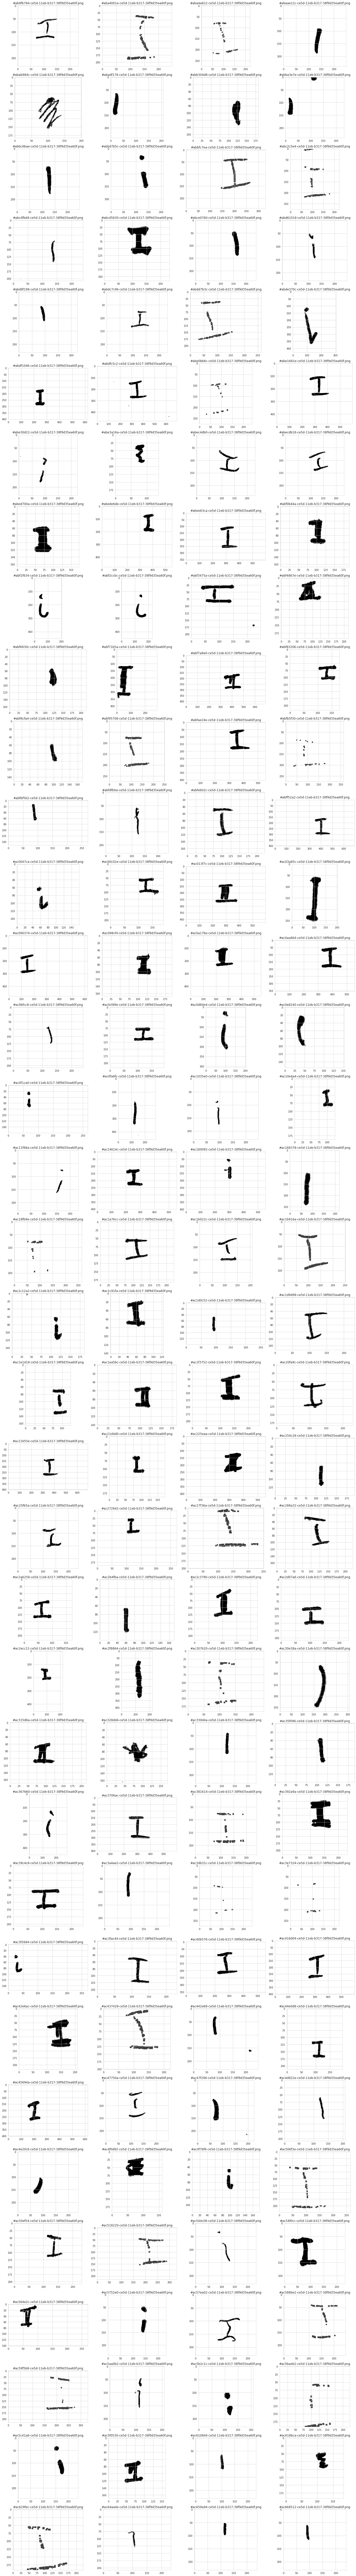

In [65]:
image_paths_in_cluster = np.array(image_paths)[kmeans_labels == 0]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [51]:
smallest_cluster = np.argmin(np.bincount(kmeans_labels))

(117, 256)

In [54]:
km = KMeans(n_clusters=2, random_state=42, verbose=0)
kmeans_labels = km.fit_predict(feature_map[kmeans_labels == smallest_cluster])

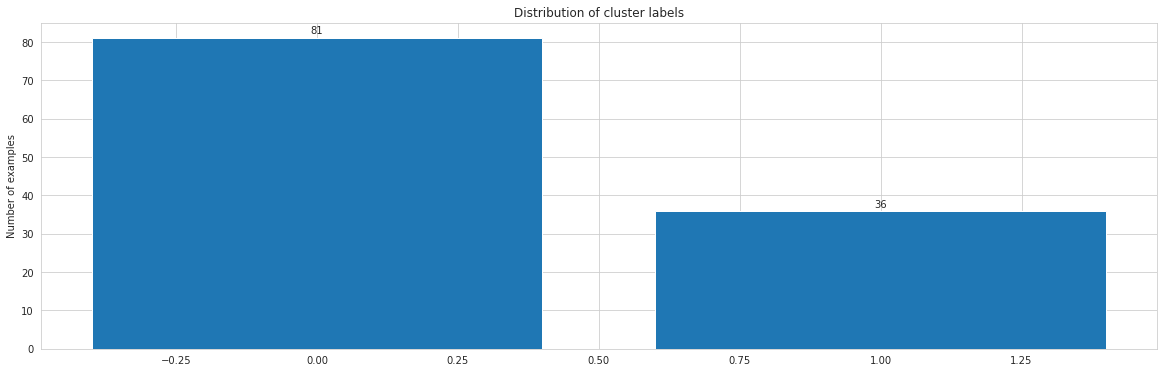

In [55]:
fig, ax = plt.subplots(figsize=(20, 6))
label_counts = np.bincount(kmeans_labels)
rects = ax.bar(range(len(label_counts)), label_counts)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % int(height), ha='center', va='bottom')
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of cluster labels");

In [56]:

smallest_cluster = np.argmin(np.bincount(kmeans_labels))
smallest_cluster

1

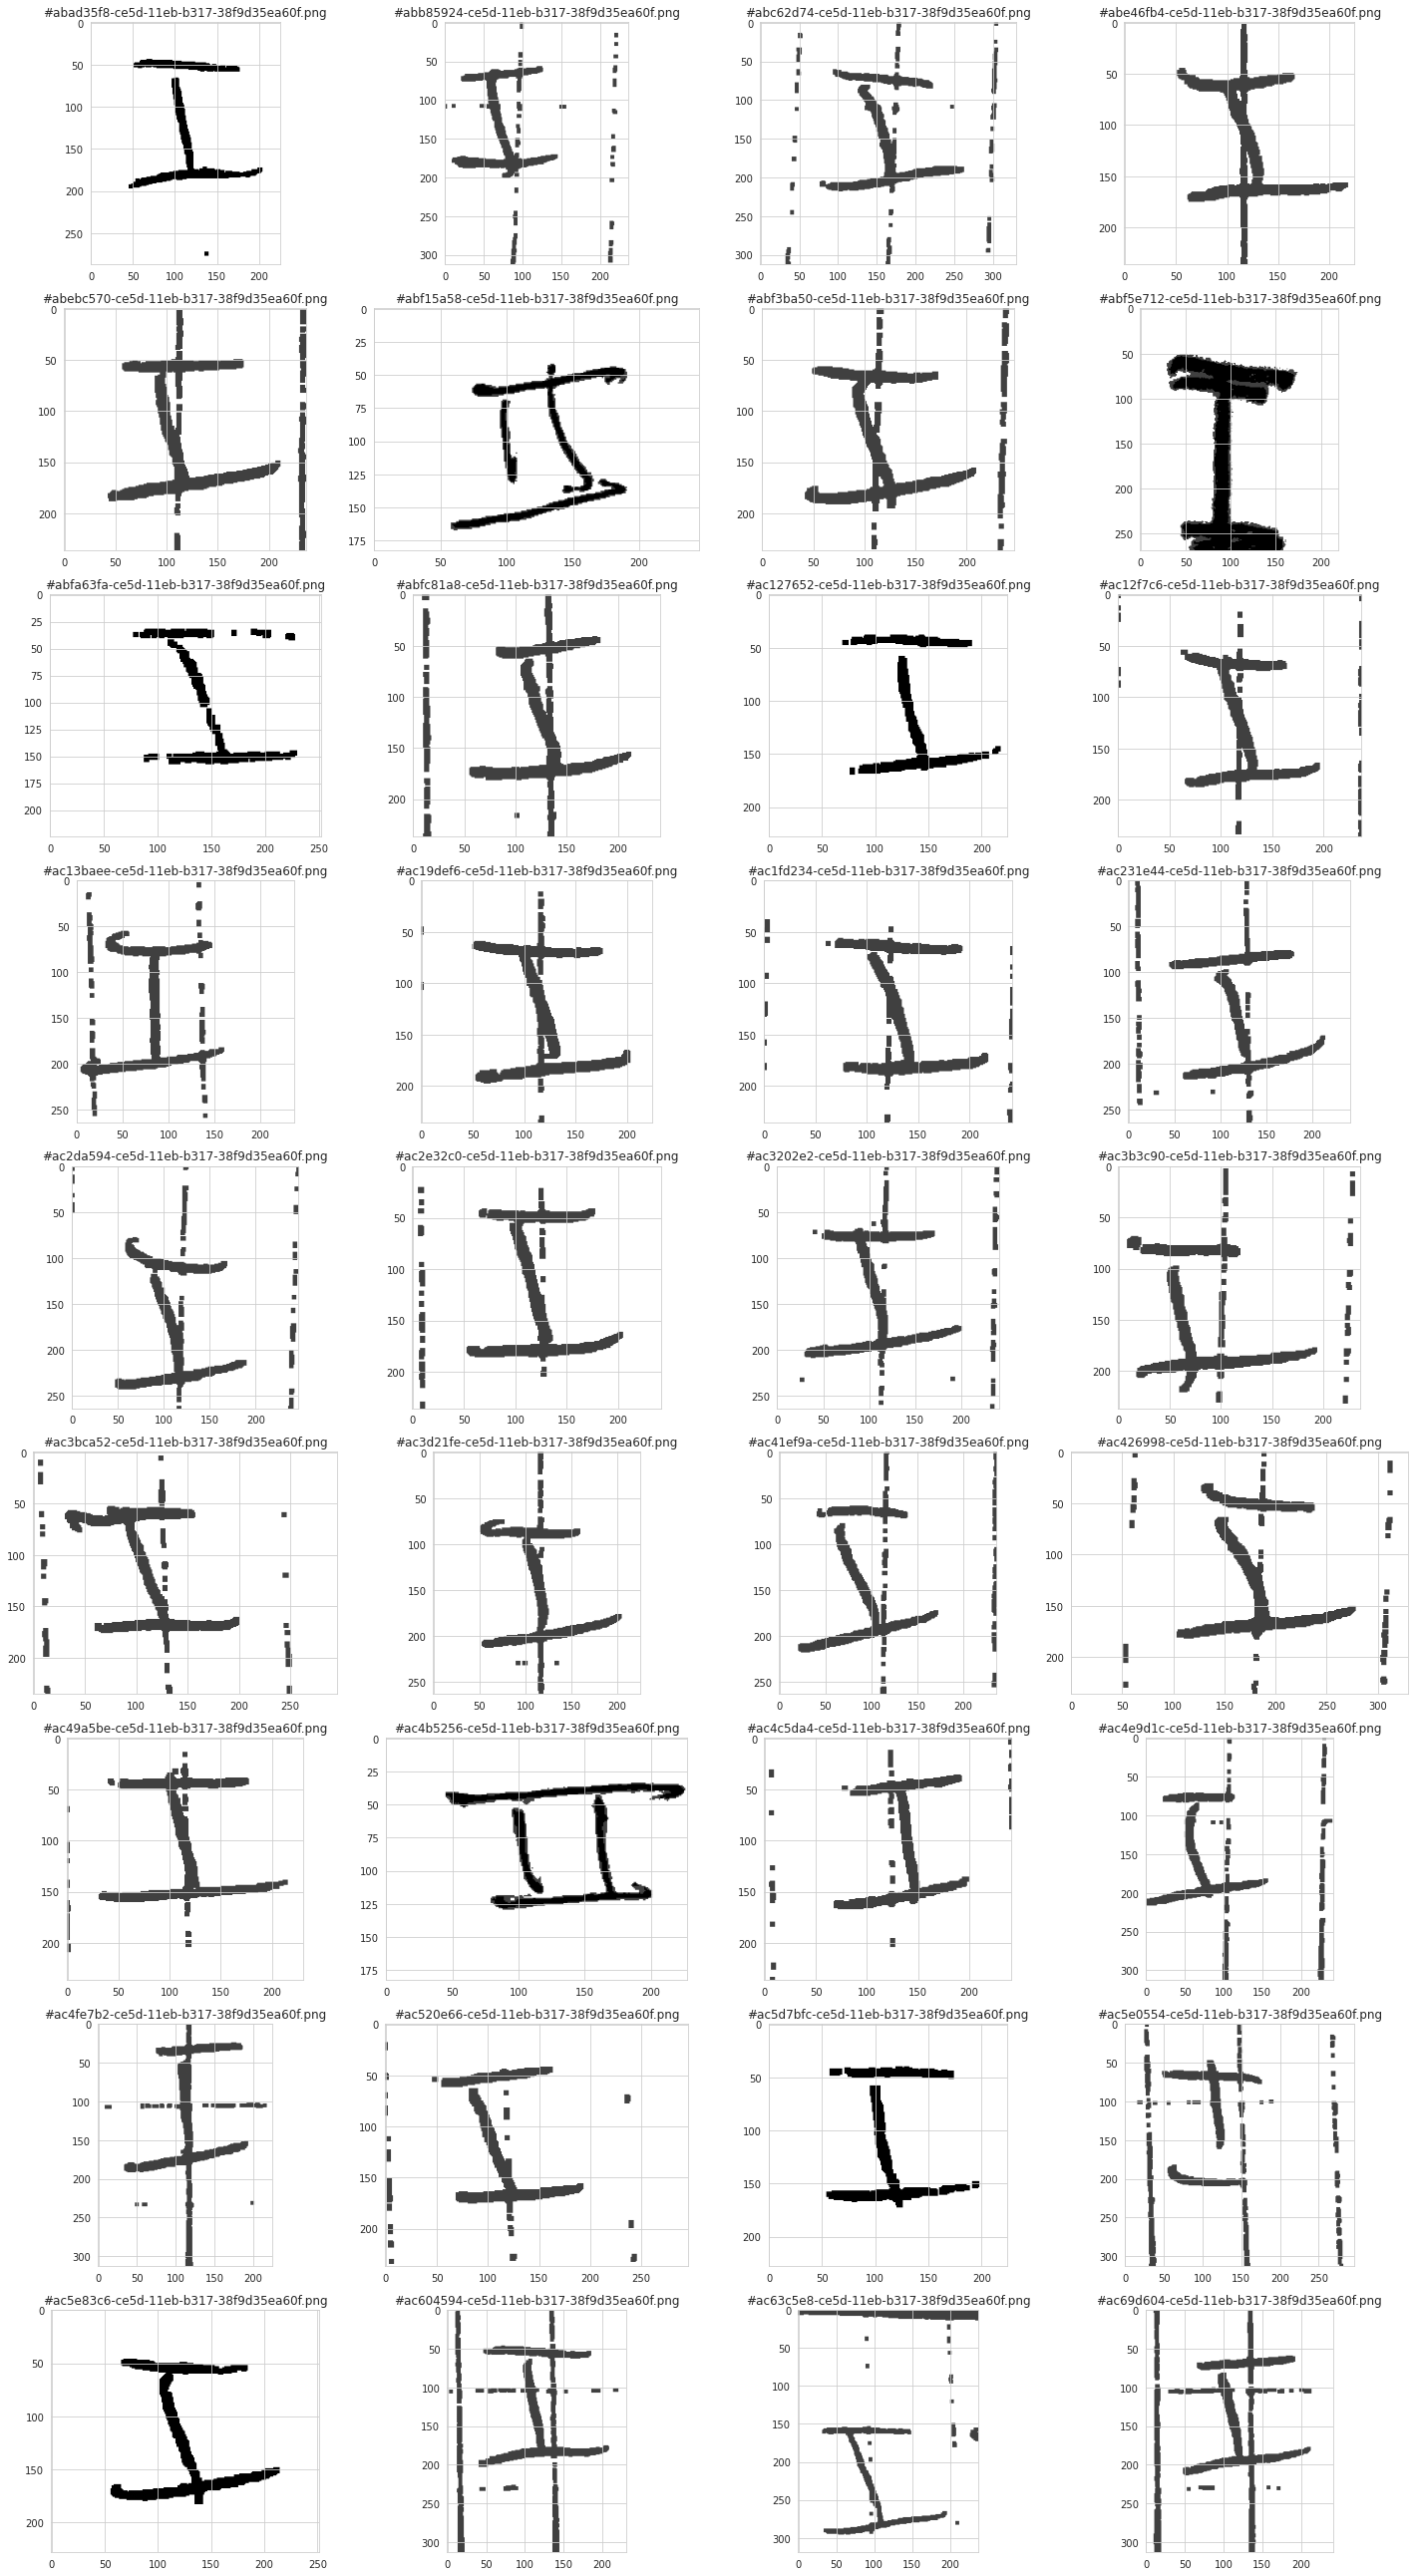

In [58]:
image_paths_in_cluster = np.array(image_paths_in_cluster)[kmeans_labels == smallest_cluster]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [59]:
image_paths_in_cluster = np.array(image_paths_in_cluster)[kmeans_labels == 0]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 36 but corresponding boolean dimension is 117